# Project 1 - Sentiment Classification 

Group 22
Group Members:  CAI, Shizhan  CHEN, Zixin  LIANG Haoran ZHANG Weiwen



## Instruction Content

1. Load & Dump the data
    1. Load the data
    1. Dump the data
1. Preprocessing
    1. Text data processing recap
    1. Explorative data analysis
1. Learning Baselines



## 1. Load & Dump the data

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

%cd /content/drive/MyDrive/comp4332-project1-cnn-trial

Mounted at /content/drive
/content/drive/MyDrive/comp4332-project1-cnn-trial


In [3]:
# import all libraries required

import pandas as pd
import numpy as np


import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

import spacy

import matplotlib.pyplot as plt




In [4]:
from itertools import chain
from collections import Counter
import keras

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

In [6]:
from tensorflow.python.keras.datasets import mnist
from tensorflow.python.keras.layers.core import Dense, Dropout, Activation, Flatten
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.utils import np_utils


In [7]:
from keras.layers import Dense, Activation, Embedding, Dropout, BatchNormalization, Input, Add, Concatenate,\
    Bidirectional, SimpleRNN, LSTM, GRU

In [8]:
from gensim.models import Word2Vec, KeyedVectors

In [9]:
import os
import tensorflow as tf

In [10]:
!pip install transformers

     |████████████████████████████████| 2.0MB 8.4MB/s 
     |████████████████████████████████| 870kB 50.5MB/s 
     |████████████████████████████████| 3.2MB 30.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=5ddb3f85b0c0f82cd9794d2d51b860ba272014762d254a57d42b1608cabedc07
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [11]:
############ Try Bert

import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score

import random

In [12]:
def load_data(split_name='train', columns=['text', 'stars']):
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        df = df.loc[:,columns]
        print("succeed!")
        return df
    except:
        print("Failed, then try to ")
        print(f"select all columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        return df

In [13]:
# Extract all the datum 

train_df = load_data('train')
valid_df = load_data('valid')
test_df = load_data('test')

train_df_full = load_data('train', columns='full')
val_df_full = load_data('valid', columns='full')
test_df_full = load_data('test', columns='full')

select [text, stars] columns from the train split
succeed!
select [text, stars] columns from the valid split
succeed!
select [text, stars] columns from the test split
Failed, then try to 
select all columns from the test split
select [f, u, l, l] columns from the train split
Failed, then try to 
select all columns from the train split
select [f, u, l, l] columns from the valid split
Failed, then try to 
select all columns from the valid split
select [f, u, l, l] columns from the test split
Failed, then try to 
select all columns from the test split


In [ ]:
train_df.head()

,text,stars
0,Nice to have a diner still around. Food was go...,4
1,"Tried this a while back, got the fried chicken...",2
2,I expected more pork selections on menu. Food ...,4
3,YUMMY!!! This place is phenomenal. It is Price...,4
4,The Truffle Macaroni & Cheese and Potatoes Au ...,5


### B. Dump the random answer

In this project, your predictions on test data are supposed to be submitted by a csv file of two columns, i.e. (review_id and stars)

Here we compose the random answer in a DataFrame and dump the answer into a csv file

In [ ]:
random_ans = pd.DataFrame(data={
    'review_id': test_df['review_id'],
    'stars': np.random.randint(0, 6, size=len(test_df))
})

In [ ]:
random_ans.head()

,review_id,stars
0,b8-ELBwhmDKcmcM8icT86g,2
1,rBpAJhIen_V-zLoXZIcROg,1
2,_pALaDG6se9OTkGGhyhnNA,3
3,ru8fpA1Uk0tTFtO5hLM49g,3
4,fRPgwuFoY6SriToXZyaOQA,2


In [ ]:
group_number = -1
random_ans.to_csv(f'{group_number}-random_ans.csv', index=False)

## 2. Preprocessing



#### A. Text data processing


In [ ]:

stopwords = set(stopwords.words('english'))
ps = PorterStemmer()

def lower(s):
    """
    :param s: a string.
    return a string with lower characters
    Note that we allow the input to be nested string of a list.
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: 'text mining is to identify useful information.'
    """
    if isinstance(s, list):
        return [lower(t) for t in s]
    if isinstance(s, str):
        return s.lower()
    else:
        raise NotImplementedError("unknown datatype")


def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)


def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     results.append(ps.stem(token))
    # return results

    return [ps.stem(token) for token in tokens]

def n_gram(tokens, n= 3):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
        return tokens
    else:
        results = list()
        for i in range(len(tokens)-n+1):
            # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
            results.append(" ".join(tokens[i:i+n]))
        return results

def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

def get_onehot_vector(feats, feats_dict):
    """
    :param data: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector


def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = [f for f, cnt in feat_cnt.most_common(max_size)]
    else:
        valid_feats = list()
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]        
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

def get_index_vector(feats, feats_dict, max_len):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    :param feats: a list of features, type: list
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(max_len, dtype=np.int64)
    for i, f in enumerate(feats):
        if i == max_len:
            break
        # get the feature index, return 1 (<unk>) if the feature is not existed
        f_idx = feats_dict.get(f, 1)
        vector[i] = f_idx
    return vector

#### B. Explorative data analysis



In [ ]:
from scipy.stats import f_oneway, wasserstein_distance, describe, spearmanr, pearsonr
from numpy import cov, corrcoef

In [ ]:
f_oneway(train_df_full['cool'], train_df_full['funny'])

F_onewayResult(statistic=0.6586907307424174, pvalue=0.41703220506531435)

In [ ]:
train_df_full.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,39rLHYJOy2774ZIUouuWLw,0,2017-06-28 21:44:02,0,ynzOFepQYSCDGdfWDWxiZw,4,Nice to have a diner still around. Food was go...,0,Sl6VgFOB-XXfFIAYp7TFkw
1,E-Kq1Yu1d6N3TL2qX0aqjA,0,2018-04-09 03:45:19,0,sQX9ncJBEdBf16AWsvO6Vg,2,"Tried this a while back, got the fried chicken...",0,gcx01pMqWzkni2UC-zoZrA
2,nWW6fBfBljiRFa4sG7TyxA,0,2014-07-19 02:00:04,0,bVIf2kqbzvif3miNe3ARNw,4,I expected more pork selections on menu. Food ...,0,Mn9VzPbrCYU4EcP_C1oBOg
3,qmIHO-6T_KEfPC9jyGDamQ,0,2011-11-11 08:10:24,0,LNj1OFxy2ool3PZANGchPA,4,YUMMY!!! This place is phenomenal. It is Price...,0,SKV1heo00fdciCbCN9Z33A
4,pKk7jCFIm96qDdk0laVT2w,1,2010-01-16 20:04:00,1,bZXxa0hO6wQlHD-MkMf4iw,5,The Truffle Macaroni & Cheese and Potatoes Au ...,1,p1r7rZYruZR92x1A649PTQ


Explore the relationship between different features

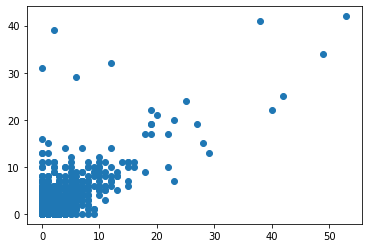

In [ ]:
# check the relationship between cool & funny
plt.scatter(train_df_full['cool'], train_df_full['funny'])

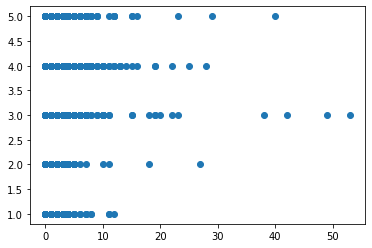

In [ ]:
# check the relationship between useful and stars
plt.scatter(train_df_full['cool'], train_df_full['stars'])

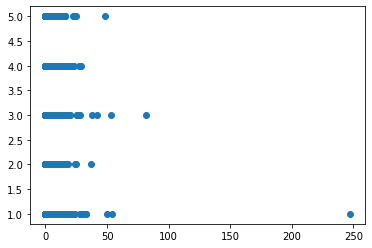

In [ ]:
# check the relationship between useful and stars
plt.scatter(train_df_full['useful'], train_df_full['stars'])

(array([2534., 1354., 1888., 2110., 2114.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <BarContainer object of 5 artists>)

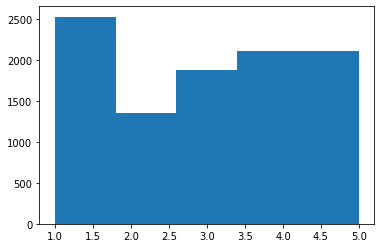

In [ ]:
plt.hist(train_df_full['stars'], bins=5)

Moreover, you may use the id feature to aggregate data samples

For example

                 business_id  funny  cool  stars
7043  -0qht1roIqleKiQkBLDkbw      1     0      3
7363  -0qht1roIqleKiQkBLDkbw      0     0      5


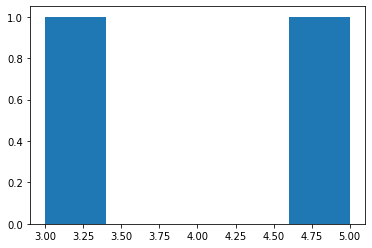

In [ ]:
for bid, sub_df in train_df_full.groupby('business_id'):
    if len(sub_df) > 1:
        print(sub_df[['business_id', 'funny', 'cool', 'stars']].head())
        plt.hist(sub_df['stars'], bins=5)
        break

In [ ]:
for bid, sub_df in train_df_full.groupby('user_id'):
    if len(sub_df) > 1:
        print(sub_df[['user_id', 'funny', 'cool', 'stars']].head())
        break

                     user_id  funny  cool  stars
1173  -SjQXQd-IRfOdUdYYwWGOQ      0     1      4
4503  -SjQXQd-IRfOdUdYYwWGOQ      0     0      1


## 3. Models


The split above is what we have done for you. You can use the data as you like.

In [ ]:
x_train_text = train_df_full['text']
x_valid_text = valid_df['text']

# x_train_useful = train_df_full['useful']
# x_valid_useful = valid_df_full['useful']

y_train = train_df['stars']
y_valid = valid_df['stars']

In [ ]:
x_train_text

0       Nice to have a diner still around. Food was go...
1       Tried this a while back, got the fried chicken...
2       I expected more pork selections on menu. Food ...
3       YUMMY!!! This place is phenomenal. It is Price...
4       The Truffle Macaroni & Cheese and Potatoes Au ...
                              ...                        
9995    I think most people like this place because of...
9996    Thought I'd give this location a try from the ...
9997    I first tried this place a while ago, and ever...
9998    Yummy yummy yummy I got the chicken fried stea...
9999    4 stars for the beer selection. 1 star for the...
Name: text, Length: 10000, dtype: object

In [ ]:
# pre-processing the data for better feature selection

In [ ]:
# extract features
train_tokens = [tokenize(text) for text in x_train_text]
valid_tokens = [tokenize(text) for text in x_valid_text]

train_stemmed = [stem(tokens) for tokens in train_tokens]
valid_stemmed = [stem(tokens) for tokens in valid_tokens]

train_stemmed = [filter_stopwords(tokens) for tokens in train_stemmed]
valid_stemmed = [filter_stopwords(tokens) for tokens in valid_stemmed]

train_2_gram = [n_gram(tokens, 2) for tokens in train_stemmed]
train_3_gram = [n_gram(tokens, 3) for tokens in train_stemmed]
valid_2_gram = [n_gram(tokens, 2) for tokens in valid_stemmed]
valid_3_gram = [n_gram(tokens, 3) for tokens in valid_stemmed]

In [ ]:
# build the feature list
# Multinomial Logistic Regression with tokenize & stopwords & stemmed & min_freq=8

max_len = 150
train_feats = list()
for i in range(len(x_train_text)):
    train_feats.append(
#         train_stemmed[i] + train_2_gram[i] + train_3_gram[i])
        train_stemmed[i])
valid_feats = list()
for i in range(len(x_valid_text)):
    valid_feats.append(
#         valid_stemmed[i] + valid_2_gram[i] + valid_3_gram[i])
        valid_stemmed[i])

# build a mapping from features to indices
feats_dict = get_feats_dict(
    chain.from_iterable(train_feats),
    min_freq=8)

# build the feats_matrix
# convert each example to a ont-hot vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack(
    [get_onehot_vector(f, feats_dict) for f in train_feats])
valid_feats_matrix = np.vstack(
    [get_onehot_vector(f, feats_dict) for f in valid_feats])

# convert labels to label_matrix
num_classes = max(y_train)
# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = keras.utils.to_categorical(y_train-1, num_classes=num_classes)
valid_label_matrix = keras.utils.to_categorical(y_valid-1, num_classes=num_classes)

Size of features: 5033


stemmed feature size: 24119


<ipython-input-44-c1708e8294f5>:24: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.loglog(range(1, len(stemmed_feat_cnt)+1),
<ipython-input-44-c1708e8294f5>:24: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.loglog(range(1, len(stemmed_feat_cnt)+1),


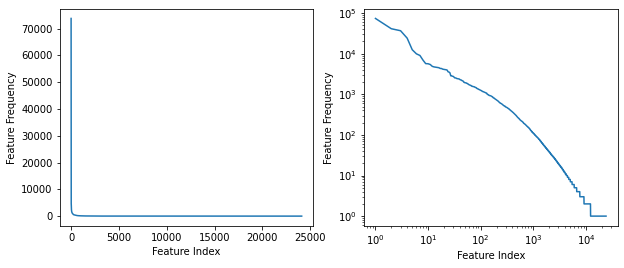

In [ ]:
# first, build a Counter for stemmed features, e.g., {"text": 2, "mine": 1}
stemmed_feat_cnt = Counter()
for feats in train_stemmed:
    stemmed_feat_cnt.update(feats)
print("stemmed feature size:", len(stemmed_feat_cnt))

# then, get the sorted features by the frequency
stemmed_feat_keys = [f for f, cnt in stemmed_feat_cnt.most_common()]

# draw linear lines and log lines for sorted features
# set the figure size
plt.figure(figsize=(10,4))
# generate two subfigures and set current as the first one
plt.subplot(1,2,1)
# draw linear lines
plt.plot(range(1, len(stemmed_feat_cnt)+1),
         [stemmed_feat_cnt[f] for f in stemmed_feat_keys])
# set labels
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
# set current as the second one
plt.subplot(1,2,2)
# draw log lines
plt.loglog(range(1, len(stemmed_feat_cnt)+1),
           [stemmed_feat_cnt[f] for f in stemmed_feat_keys],
           basex=10, basey=10)
# set labels
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
plt.show()

<ipython-input-45-c5e144309663>:33: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.loglog(range(1, len(stemmed_feat_cnt)+1),
<ipython-input-45-c5e144309663>:33: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.loglog(range(1, len(stemmed_feat_cnt)+1),
<ipython-input-45-c5e144309663>:36: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.loglog(range(1, len(bi_gram_feat_cnt)+1),
<ipython-input-45-c5e144309663>:36: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases lat

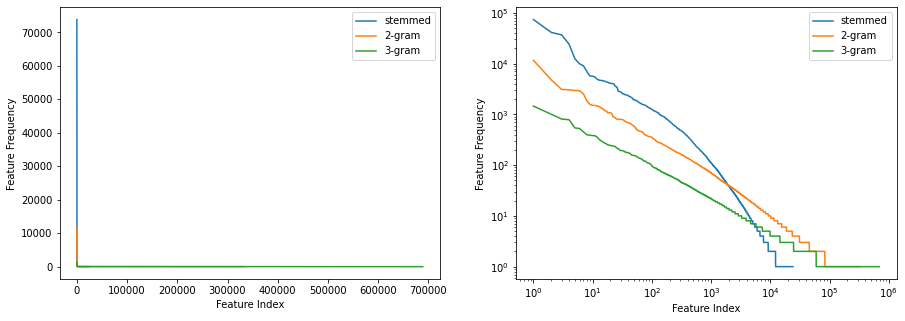

stemmed feature size: 24119
2-gram feature size: 331339
3-gram feature size: 688795


In [ ]:
# build Counters for 2-gram features and 3-gram features
bi_gram_feat_cnt = Counter()
for feats in train_2_gram:
    bi_gram_feat_cnt.update(feats)
    
tri_gram_feat_cnt = Counter()
for feats in train_3_gram:
    tri_gram_feat_cnt.update(feats)

# then, get the sorted features by the frequency
bi_gram_feat_keys = [f for f, cnt in bi_gram_feat_cnt.most_common()]
tri_gram_feat_keys = [f for f,cnt in tri_gram_feat_cnt.most_common()]

# draw linear lines and log lines for sorted features
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
# put the four linear lines together
plt.plot(range(1, len(stemmed_feat_cnt)+1),
         [stemmed_feat_cnt[f] for f in stemmed_feat_keys],
         label="stemmed")
plt.plot(range(1, len(bi_gram_feat_cnt)+1),
         [bi_gram_feat_cnt[f] for f in bi_gram_feat_keys],
         label="2-gram")
plt.plot(range(1, len(tri_gram_feat_cnt)+1),
         [tri_gram_feat_cnt[f] for f in tri_gram_feat_keys],
         label="3-gram")
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
# show the legend
plt.legend()
plt.subplot(1,2,2)
# put the four log lines together
plt.loglog(range(1, len(stemmed_feat_cnt)+1),
         [stemmed_feat_cnt[f] for f in stemmed_feat_keys],
           basex=10, basey=10, label="stemmed")
plt.loglog(range(1, len(bi_gram_feat_cnt)+1),
         [bi_gram_feat_cnt[f] for f in bi_gram_feat_keys],
           basex=10, basey=10, label="2-gram")
plt.loglog(range(1, len(tri_gram_feat_cnt)+1),
         [tri_gram_feat_cnt[f] for f in tri_gram_feat_keys],
           basex=10, basey=10, label="3-gram")
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
# show the legend
plt.legend()
plt.show()

print("stemmed feature size:", len(stemmed_feat_cnt))
print("2-gram feature size:", len(bi_gram_feat_cnt))
print("3-gram feature size:", len(tri_gram_feat_cnt))

In [ ]:
print("stemmed features > 10:",
      len([f for f, cnt in stemmed_feat_cnt.items() if cnt > 10]))
print("2-gram features > 10:",
      len([f for f, cnt in bi_gram_feat_cnt.items() if cnt > 10]))
print("3-gram features > 10:",
      len([f for f, cnt in tri_gram_feat_cnt.items() if cnt > 10]))

stemmed features > 10: 4217
2-gram features > 10: 9173
3-gram features > 10: 2870


In [ ]:
print("stemmed features top 10:",
      stemmed_feat_keys[:10])
print("2-gram features top 10:",
      bi_gram_feat_keys[:10])
print("3-gram features top 10:",
      tri_gram_feat_keys[:10])

stemmed features top 10: ['.', ',', 'I', 'wa', '!', 'thi', "n't", "'s", 'food', 'place']
2-gram features top 10: ['. I', ', I', '! !', '. We', '. It', 'I wa', 'thi place', "I 'm", 'I would', "I n't"]
3-gram features top 10: ['! ! !', '. It wa', ". It 's", '. I wa', ". I 'm", '. I would', ". I n't", 'thi place .', ', I wa', ". I 've"]


In [ ]:
len(feats_dict)

5033

In [ ]:
# Model Selection

In [ ]:
model_test = LogisticRegression(C=1.0, tol=1e-6, multi_class='multinomial', solver='newton-cg')
model_test.fit(train_feats_matrix, y_train)

LogisticRegression(multi_class='multinomial', solver='newton-cg', tol=1e-06)

In [ ]:
#Multinomial Logistic Regression with tokenize & stopwords & stemmed & min_freq=8
y_valid = valid_df['stars']
y_pred = model_test.predict(valid_feats_matrix)
print(classification_report(y_valid, y_pred))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

              precision    recall  f1-score   support

           1       0.72      0.75      0.74       517
           2       0.35      0.26      0.30       278
           3       0.42      0.43      0.43       344
           4       0.45      0.49      0.47       427
           5       0.65      0.64      0.65       434

    accuracy                           0.55      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.54      0.55      0.55      2000




[[389  64  36  15  13]
 [ 94  73  72  30   9]
 [ 30  55 149  92  18]
 [ 17  12  79 210 109]
 [ 11   6  19 119 279]]
accuracy 0.55


### Try Word2Vec with LSTM

In [ ]:

# first save the reviews to txt
x_w2v_train = train_df['text']
x_w2v_train.to_csv('x_w2v_train.txt', header=True, index=False, sep='\t', mode='a')

In [ ]:
def build_RNN(input_length, vocab_size, embedding_size,
              hidden_size, output_size,
              num_rnn_layers, num_mlp_layers,
              rnn_type="lstm",
              bidirectional=False,
              embedding_matrix=None,
              activation="tanh",
              dropout_rate=0.0,
              batch_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="Adam",
              learning_rate=0.001,
              metric="accuracy"):
    """
    :param input_length: the maximum length of sentences, type: int
    :param vocab_size: the vacabulary size, type: int
    :param embedding_size: the dimension of word representations, type: int
    :param hidden_size: the dimension of the hidden states, type: int
    :param output_size: the dimension of the prediction, type: int
    :param num_rnn_layers: the number of layers of the RNN, type: int
    :param num_mlp_layers: the number of layers of the MLP, type: int
    :param rnn_type: the type of RNN, type: str
    :param bidirectional: whether to use bidirectional rnn, type: bool
    :param activation: the activation type, type: str
    :param dropout_rate: the probability of dropout, type: float
    :param batch_norm: whether to enable batch normalization, type: bool
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a RNN for text classification,
    # activation document: https://keras.io/activations/
    # dropout document: https://keras.io/layers/core/#dropout
    # embedding document: https://keras.io/layers/embeddings/#embedding
    # recurrent layers document: https://keras.io/layers/recurrent
    # batch normalization document: https://keras.io/layers/normalization/
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    x = Input(shape=(input_length,))
    
    ################################
    ###### Word Representation #####
    ################################
    # word representation layer
    if embedding_matrix is not None:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                        trainable=False)(x)
    else:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=0))(x)
    
    ################################
    ####### Recurrent Layers #######
    ################################
    # recurrent layers
    if rnn_type == "rnn":
        fn = SimpleRNN
    elif rnn_type == "lstm":
        fn = LSTM
    elif rnn_type == "gru":
        fn = GRU
    else:
        raise NotImplementedError
    h = emb
    for i in range(num_rnn_layers):
        is_last = (i == num_rnn_layers-1)
        if bidirectional:
            h = Bidirectional(fn(hidden_size,
                                 kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                                 recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                                 return_sequences=not is_last))(h)
        else:
            h = fn(hidden_size,
                   kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                   recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                   return_sequences=not is_last)(h)
        h = Dropout(dropout_rate, seed=0)(h)
    
    ################################
    #### Fully Connected Layers ####
    ################################
    # multi-layer perceptron
    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,
                      kernel_initializer=keras.initializers.he_normal(seed=0),
                      bias_initializer="zeros",
                      kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
        # add batch normalization layer
        if batch_norm:
            new_h = BatchNormalization()(new_h)
        # add residual connection
        if i == 0:
            h = new_h
        else:
            h = Add()([h, new_h])
        # add activation
        h = Activation(activation)(h)
    y = Dense(output_size,
              activation="softmax",
              kernel_initializer=keras.initializers.he_normal(seed=0),
              bias_initializer="zeros")(h)
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model = Model(x, y)
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

In [ ]:
filepath = '/Users/cinder/Desktop/COMP4332_project_1/comp4332-project1-cnn-trial/x_w2v_train.txt'
savepath = '/Users/cinder/Desktop/COMP4332_project_1/comp4332-project1-cnn-trial/word2vec.model'

/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [ ]:
word_vectors = Word2Vec(corpus_file=filepath, vector_size=100, epochs=10, sg=1).wv
word_vectors.save(savepath)

In [ ]:
embedding_matrix_ex = np.zeros((len(feats_dict), 100), dtype=np.float32)
wv = KeyedVectors.load(savepath, mmap='r')
print("number of words:", len(wv), "word dimension:", wv.vector_size)
for i in range(len(wv)):
    word = wv.index_to_key[i]
    word_idx = feats_dict.get(word, -1)
    if word_idx != -1:
        embedding_matrix_ex[word_idx] = wv[word]
print(embedding_matrix_ex[:5])

number of words: 29824 word dimension: 100
[[-3.25290233e-01  3.92701060e-01 -2.69986868e-01  3.16164881e-01
  -7.13994324e-01 -9.60341871e-01 -2.36831959e-02 -9.52675268e-02
  -1.80247977e-01 -1.95862874e-01 -3.21728826e-01 -5.03894746e-01
  -9.36819315e-02 -8.81114542e-01  5.43669105e-01 -1.30297646e-01
   5.54483473e-01 -7.07324669e-02 -5.03927648e-01 -3.26483905e-01
  -8.56881496e-03  3.65180969e-02 -2.93729842e-01  4.01948811e-03
  -1.07995486e-02 -1.88596606e-01 -6.27012014e-01  4.92968291e-01
  -5.54608822e-01  2.34811395e-01  5.24150014e-01 -1.78299829e-01
   5.89855313e-01 -9.11453515e-02  3.09500396e-01 -2.25572735e-01
   6.30509436e-01  3.29057634e-01 -2.73922533e-01 -8.97676349e-01
   1.48662657e-01 -7.81213999e-01 -4.16494519e-01  2.32790392e-02
   6.49805427e-01  6.22834079e-02 -6.29635751e-02 -6.22230589e-01
   1.66624770e-01 -1.50451407e-01  3.48041445e-01 -4.69456822e-01
  -1.01598382e-01  2.74266243e-01  1.28946707e-01  1.14109114e-01
   8.04716572e-02 -3.00969303e-01

In [ ]:
# build the feature list
# W2V RNN

maximum_len = 100
train_w2v_feats = list()
for i in range(len(x_train_text)):
    train_w2v_feats.append(
#         train_stemmed[i] + train_2_gram[i] + train_3_gram[i])
        train_stemmed[i])
valid_w2v_feats = list()
for i in range(len(x_valid_text)):
    valid_w2v_feats.append(
#         valid_stemmed[i] + valid_2_gram[i] + valid_3_gram[i])
        valid_stemmed[i])

# build a mapping from features to indices
feats_w2v_dict = get_feats_dict(
    chain.from_iterable(train_w2v_feats),
    min_freq=8)

# build the feats_matrix
# convert each example to a ont-hot vector, and then stack vectors as a matrix
train_w2v_feats_matrix = np.vstack(
    [get_index_vector(f, feats_w2v_dict, maximum_len) for f in train_w2v_feats])
valid_w2v_feats_matrix = np.vstack(
    [get_index_vector(f, feats_w2v_dict, maximum_len) for f in valid_w2v_feats])

# convert labels to label_matrix
num_classes = max(y_train)
# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_w2v_label_matrix = keras.utils.to_categorical(y_train-1, num_classes=num_classes)
valid_w2v_label_matrix = keras.utils.to_categorical(y_valid-1, num_classes=num_classes)

Size of features: 5033


In [ ]:
# Code for LSTM + W2V

### Try Logistical (multinomial)


In [ ]:

# The result shows that multinomial is better!
x_demo_train = train_df['text']
y_demo_train = train_df['stars']

tfidf = TfidfVectorizer(tokenizer=tokenize)
lr = LogisticRegression(C=1.0, tol=1e-6, multi_class='multinomial', solver='newton-cg')
steps = [('tfidf', tfidf),('lr', lr)]
pipe_demo = Pipeline(steps)
print(pipe_demo)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7fcf98cd5ee0>)),
                ('lr',
                 LogisticRegression(multi_class='multinomial',
                                    solver='newton-cg', tol=1e-06))])


In [ ]:
pipe_demo.fit(x_demo_train, y_demo_train)

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7fcf98cd5ee0>)),
                ('lr',
                 LogisticRegression(multi_class='multinomial',
                                    solver='newton-cg', tol=1e-06))])

In [ ]:
x_demo_valid = valid_df['text']
y_demo_valid = valid_df['stars']
y_demo_pred = pipe_demo.predict(x_demo_valid)
print(classification_report(y_demo_valid, y_demo_pred))
print("\n\n")
print(confusion_matrix(y_demo_valid, y_demo_pred))
print('accuracy', np.mean(y_demo_valid == y_demo_pred))

              precision    recall  f1-score   support

           1       0.69      0.87      0.77       517
           2       0.44      0.21      0.28       278
           3       0.48      0.47      0.47       344
           4       0.51      0.54      0.53       427
           5       0.71      0.71      0.71       434

    accuracy                           0.60      2000
   macro avg       0.57      0.56      0.55      2000
weighted avg       0.59      0.60      0.59      2000




[[448  31  23   8   7]
 [111  58  78  22   9]
 [ 49  33 160  93   9]
 [ 16   8  69 231 103]
 [ 22   2   5  97 308]]
accuracy 0.6025


### Try Logistic R with stop_words

In [ ]:
# Demo + hyperparameter training
# The result showing that without stop_words the performance is better!
x_demo_h_train = train_df['text']
y_demo_h_train = train_df['stars']

tfidf_h = TfidfVectorizer(tokenizer=tokenize, stop_words = 'english')
lr = LogisticRegression(C=1.0, tol=1e-6, multi_class='multinomial', solver='newton-cg')
steps_h = [('tfidf_h', tfidf_h),('lr', lr)]
pipe_demo_h = Pipeline(steps_h)
print(pipe_demo_h)


Pipeline(steps=[('tfidf_h',
                 TfidfVectorizer(stop_words='english',
                                 tokenizer=<function tokenize at 0x7fcf98cd5ee0>)),
                ('lr',
                 LogisticRegression(multi_class='multinomial',
                                    solver='newton-cg', tol=1e-06))])


In [ ]:
pipe_demo_h.fit(x_demo_h_train, y_demo_h_train)

Pipeline(steps=[('tfidf_h',
                 TfidfVectorizer(stop_words='english',
                                 tokenizer=<function tokenize at 0x7fcf98cd5ee0>)),
                ('lr',
                 LogisticRegression(multi_class='multinomial',
                                    solver='newton-cg', tol=1e-06))])

In [ ]:
x_demo_h_valid = valid_df['text']
y_demo_h_valid = valid_df['stars']
y_demo_h_pred = pipe_demo_h.predict(x_demo_h_valid)
print(classification_report(y_demo_h_valid, y_demo_h_pred))
print("\n\n")
print(confusion_matrix(y_demo_h_valid, y_demo_h_pred))
print('accuracy', np.mean(y_demo_h_valid == y_demo_h_pred))

              precision    recall  f1-score   support

           1       0.68      0.86      0.76       517
           2       0.44      0.22      0.30       278
           3       0.44      0.42      0.43       344
           4       0.51      0.52      0.51       427
           5       0.69      0.69      0.69       434

    accuracy                           0.59      2000
   macro avg       0.55      0.54      0.54      2000
weighted avg       0.57      0.59      0.57      2000




[[447  27  26   6  11]
 [113  62  71  26   6]
 [ 51  40 145  94  14]
 [ 21   9  69 222 106]
 [ 23   4  15  91 301]]
accuracy 0.5885


### TRY BERT (Best model)

In [14]:
train_bert_df = train_df
valid_bert_df = valid_df
test_bert_df = test_df

In [15]:
for i in range(len(train_bert_df)):
    train_bert_df['stars'][i] = train_bert_df['stars'][i] -1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
for i in range(len(valid_bert_df)):
    valid_bert_df['stars'][i] = valid_bert_df['stars'][i] -1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    train_bert_df['text'], 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    valid_bert_df['text'], 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    test_bert_df['text'], 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)




input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_bert_df['stars'])

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(valid_bert_df['stars'])

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']


dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataset_test = TensorDataset(input_ids_test, attention_masks_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [18]:
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=5,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [152]:
batch_size = 20

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)
dataloader_test = DataLoader(dataset_test, 
                                   sampler=SequentialSampler(dataset_test), 
                                   batch_size=batch_size)

In [153]:
optimizer = AdamW(bert_model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 2

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [21]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [154]:
seed_val = 20
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    bert_model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = bert_model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    bert_model = bert_model.to(device)
    bert_model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        bert_model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        # bert_model = bert_model.to(device)
        outputs = bert_model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(bert_model.state_dict(), f'./finetuned_BERT_epoch_{epoch}.bert_model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')



Epoch 1
Training loss: 0.012704895866267179
Validation loss: 4.050705887079239
F1 Score (Weighted): 0.6252101760139549



Epoch 2
Training loss: 0.007840853588450046
Validation loss: 3.8791826474666595
F1 Score (Weighted): 0.6430743174920999



In [24]:
def evaluate_test(dataloader_val):

    bert_model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = bert_model(**inputs)
            print(outputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [56]:
def predict(dataloader_test):

    bert_model.eval()
    
    loss_test_total = 0
    predictions = []
    
    for batch in dataloader_test:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                 }

        with torch.no_grad():        
            outputs = bert_model(**inputs)
            # print(outputs)
            
        
        logits = outputs[0]
        

        logits = logits.detach().cpu().numpy()
        predictions.append(logits)
    
    
    
    predictions = np.concatenate(predictions, axis=0)
            
    return predictions

In [139]:
test_predictions= predict(dataloader_test)

In [114]:
test_predictions

array([[-2.5605865, -0.7711997,  8.77281  , -2.1461902, -5.10825  ],
       [-2.4168868, -2.6607456, -2.8782825, -1.4297142, 10.412367 ],
       [-2.64769  , -2.8689756,  9.800759 , -3.0284176, -3.1300013],
       ...,
       [-2.6052732, -2.885942 , -3.1639674, -0.6934181, 10.4231825],
       [-2.4272456, -3.5028832, -2.127954 , 10.198812 , -1.0336753],
       [-2.3218057, -3.035021 , -2.2275927, 10.275491 , -1.6301703]],
      dtype=float32)

In [59]:
true_vals

array([4, 2, 1, ..., 4, 2, 3])

In [140]:
list_pre = predictions.tolist()
pre_vals = []

for i in range(len(list_pre)):
    pre_vals.append(list_pre[i].index(max(list_pre[i])))


In [116]:
true_list = true_vals.tolist()

In [141]:
k = 0
for i in range(len(true_list)):
    if (pre_vals[i] == true_list[i]):
        k +=1

In [142]:
k/2000

0.644

In [88]:
true_val_ans = []
for i in range(len(true_list)):
  true_val_ans.append(true_list[i]+1)

In [89]:
true_val = pd.DataFrame(data={
    'review_id': val_df_full['review_id'],
    'stars': true_val_ans
})

In [90]:
true_val.to_csv(f'group22-true_ans.csv', index=False)

In [82]:
final_valid_ans = []
for i in range(len(pre_vals)):
  final_valid_ans.append(pre_vals[i]+1)

In [84]:
val_ans = pd.DataFrame(data={
    'review_id': val_df_full['review_id'],
    'stars': final_valid_ans
})

In [86]:
val_ans.to_csv(f'group22-val_ans.csv', index=False)

In [143]:
# start the testing labels
list_test_pre = test_predictions.tolist()
test_pre_vals = []

for i in range(len(list_test_pre)):
    test_pre_vals.append(list_test_pre[i].index(max(list_test_pre[i])))

In [144]:
final_test_ans = []

for i in range(len(test_pre_vals)):
  final_test_ans.append(test_pre_vals[i]+1)

In [145]:
final_test_ans[-5:]

[3, 4, 5, 4, 4]

In [146]:
test_ans = pd.DataFrame(data={
    'review_id': test_df['review_id'],
    'stars': final_test_ans
})

In [124]:
test_ans

,review_id,stars
0,b8-ELBwhmDKcmcM8icT86g,3
1,rBpAJhIen_V-zLoXZIcROg,5
2,_pALaDG6se9OTkGGhyhnNA,3
3,ru8fpA1Uk0tTFtO5hLM49g,1
4,fRPgwuFoY6SriToXZyaOQA,1
...,...,...
1995,oZxqo6rspUimmoqKl0_qdA,3
1996,C_oCpNq91uTtOYUs2cChdg,4
1997,qMrxDB5fm8wIzexUp643xQ,5
1998,HrejfPp6Xduy5Pv7i-is1A,4


In [147]:
# test_pre_vals
test_ans.to_csv(f'group22-test0.648_ans.csv', index=False)